In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks

In [12]:
df = pd.read_csv("test_dataset.csv")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641482 entries, 0 to 1641481
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   company_id      1641482 non-null  int64
 1   industry_id     1641482 non-null  int64
 2   topic_id        1641482 non-null  int64
 3   category_id     1641482 non-null  int64
 4   week            1641482 non-null  int64
 5   interest_level  1641482 non-null  int64
dtypes: int64(6)
memory usage: 75.1 MB


***EDA***

In [ ]:
df.isnull().sum() # no missing values

company_id        0
industry_id       0
topic_id          0
category_id       0
week              0
interest_level    0
dtype: int64

In [ ]:
df.describe() #interest level is between 0-100!

,company_id,industry_id,topic_id,category_id,week,interest_level
count,1.641482e+06,1.641482e+06,1.641482e+06,1.641482e+06,1.641482e+06,1.641482e+06
mean,4.332134e+03,5.823454e+01,6.220209e+01,1.029007e+01,6.260332e+00,2.258879e+01
std,2.542727e+03,4.060059e+01,3.061275e+01,3.423136e+00,3.721889e+00,7.229663e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.077000e+03,2.300000e+01,3.900000e+01,1.000000e+01,3.000000e+00,1.800000e+01
50%,4.330000e+03,5.500000e+01,6.700000e+01,1.200000e+01,6.000000e+00,2.300000e+01
75%,6.539000e+03,9.600000e+01,8.500000e+01,1.200000e+01,1.000000e+01,2.500000e+01
max,8.716000e+03,1.290000e+02,1.130000e+02,1.300000e+01,1.200000e+01,1.000000e+02


**Lets explore interest levels**

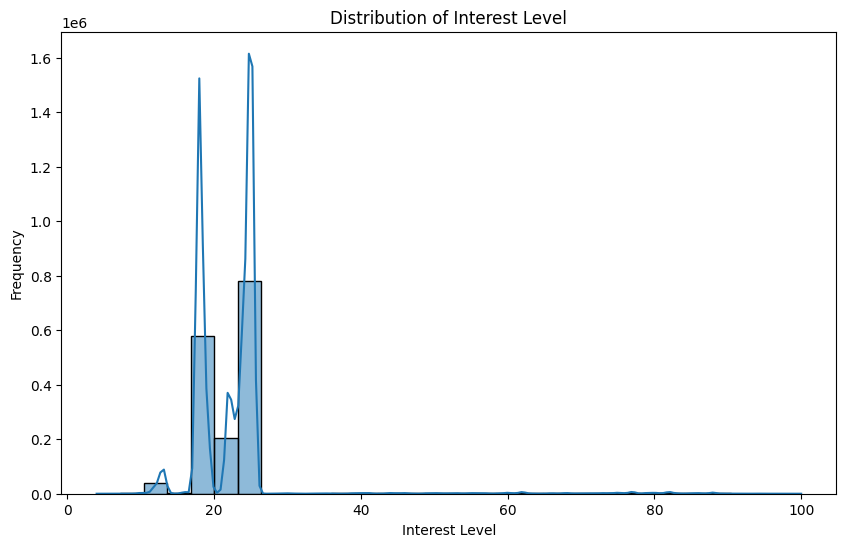

In [ ]:
# Plotting the distribution of 'interest_level'
plt.figure(figsize=(10, 6))
sns.histplot(df['interest_level'], bins=30, kde=True)
plt.title('Distribution of Interest Level')
plt.xlabel('Interest Level')
plt.ylabel('Frequency')
plt.show()

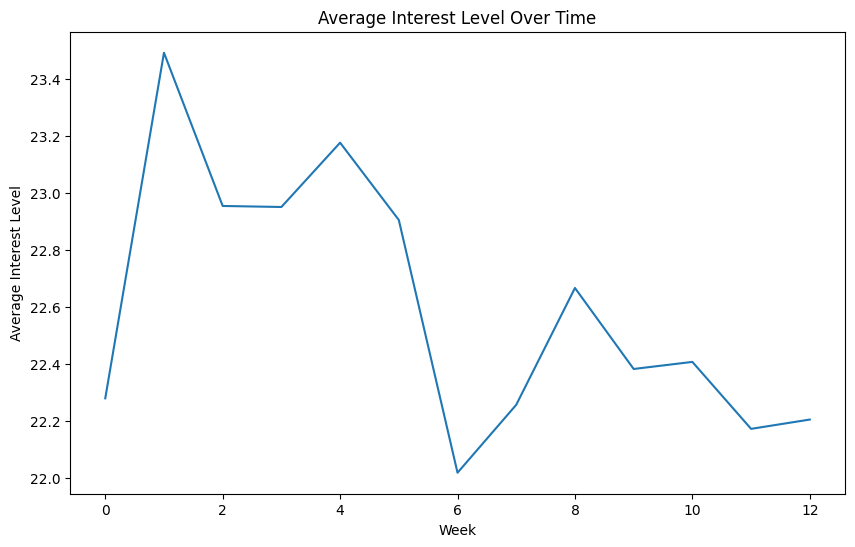

In [ ]:
# Plotting average interest level over time
weekly_interest = df.groupby('week')['interest_level'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_interest, x='week', y='interest_level')
plt.title('Average Interest Level Over Time')
plt.xlabel('Week')
plt.ylabel('Average Interest Level')
plt.show()

**Explore mappings between topic_id/category_id and company_id/industry_id**

In [ ]:
topic_category_mapping = df.groupby('topic_id')['category_id'].nunique()

discrepancies_topic_category = topic_category_mapping[topic_category_mapping > 1]

if discrepancies_topic_category.empty:
    print("Each topic_id maps to exactly one category_id. No discrepancies found.")
else:
    print("Discrepancies found in topic_id to category_id mapping:")
    print(discrepancies_topic_category)

Each topic_id maps to exactly one category_id. No discrepancies found.


In [ ]:
company_industry_mapping = df.groupby('company_id')['industry_id'].nunique()

discrepancies_company_industry = company_industry_mapping[company_industry_mapping > 1]

if discrepancies_company_industry.empty:
    print("Each company_id maps to exactly one industry_id. No discrepancies found.")
else:
    print("Discrepancies found in company_id to industry_id mapping:")
    print(discrepancies_company_industry)

Each company_id maps to exactly one industry_id. No discrepancies found.


**Explore missing weeks for company_id, topic_id pairs**

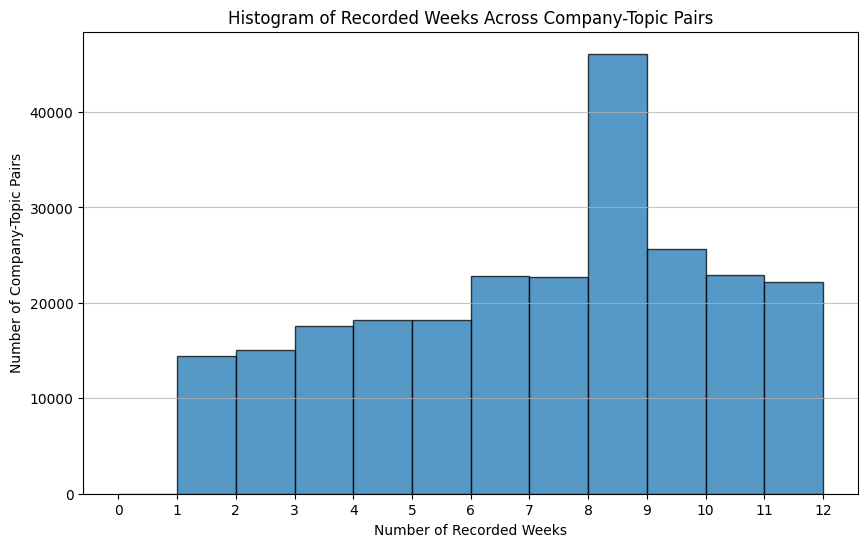

In [ ]:
all_combinations = pd.MultiIndex.from_product([
    df['company_id'].unique(),
    df['topic_id'].unique(),
    range(df['week'].min(), df['week'].max() + 1)
], names=['company_id', 'topic_id', 'week']).to_frame(index=False)


df_full = pd.merge(all_combinations, df, on=['company_id', 'topic_id', 'week'], how='left')


df_full['is_missing'] = df_full['interest_level'].isna()
max_weeks_per_pair = df_full.groupby(['company_id', 'topic_id'])['week'].nunique().reset_index(name='total_weeks_present')


missing_weeks_count = df_full.groupby(['company_id', 'topic_id'])['is_missing'].sum().reset_index(name='missing_weeks_count')


missing_analysis = pd.merge(missing_weeks_count, max_weeks_per_pair, on=['company_id', 'topic_id'])


missing_analysis['recorded_weeks_count'] = missing_analysis['total_weeks_present'] - missing_analysis['missing_weeks_count']

# include only pairs with at least one record
missing_analysis = missing_analysis[missing_analysis['recorded_weeks_count'] > 0]


plt.figure(figsize=(10, 6))
plt.hist(missing_analysis['recorded_weeks_count'], bins=range(int(missing_analysis['recorded_weeks_count'].max())), alpha=0.75, edgecolor='black')
plt.xlabel('Number of Recorded Weeks')
plt.ylabel('Number of Company-Topic Pairs')
plt.title('Histogram of Recorded Weeks Across Company-Topic Pairs')
plt.xticks(range(int(missing_analysis['recorded_weeks_count'].max())))
plt.grid(axis='y', alpha=0.75)
plt.show()

*Explore the first week for each company/topic pair.*

In [64]:
first_week_df = df.groupby(['company_id', 'topic_id'])['week'].min().reset_index(name='first_week')
print(first_week_df['first_week'].describe())

count    246254.000000
mean          2.639385
std           3.514554
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max          12.000000
Name: first_week, dtype: float64


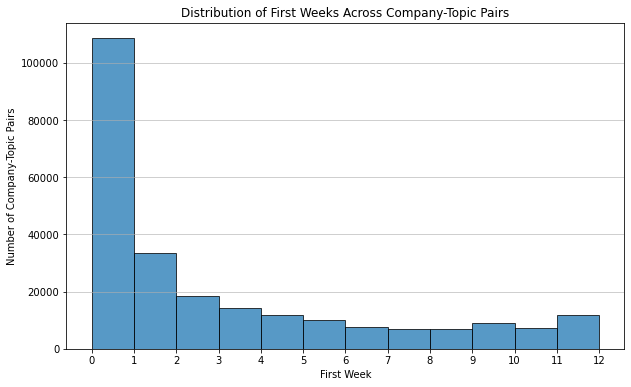

In [65]:
plt.figure(figsize=(10, 6))
plt.hist(first_week_df['first_week'], bins=range(int(first_week_df['first_week'].min()), int(first_week_df['first_week'].max()) + 1), alpha=0.75, edgecolor='black')
plt.xlabel('First Week')
plt.ylabel('Number of Company-Topic Pairs')
plt.title('Distribution of First Weeks Across Company-Topic Pairs')
plt.xticks(range(int(first_week_df['first_week'].min()), int(first_week_df['first_week'].max()) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()


Not all company/topic pairs start from week 0, this is something to keep in mind.

***Suggestions on how to assess "the volatility of the scores". Please, design a metric to show how
good is the solution comparing to the baseline (original scores).***

I will use a unified metric combining correalation, volatility reduction and peak detection accuracy to assess the effectiveness of my trend scoring method.

The individual metrics are normalized and combined into a single weighted score. The implementation is below:

In [14]:
def evaluate_trend_scores(df, original_col, trend_col):
    """
    Evaluates the trend scoring method using various metrics.

    Parameters:
    - df: DataFrame containing the data.
    - original_col: String name of the column with original interest levels.
    - trend_col: String name of the column with calculated trend scores.

    Returns:
    - A dictionary with calculated metrics ( Correalation, Volatility, PDA).
    """

    analysis_df = df.dropna(subset=[original_col, trend_col])




    correlation_coefficient = np.corrcoef(analysis_df[original_col], analysis_df[trend_col])[0, 1]

    original_volatility = analysis_df[original_col].std()
    trend_volatility = analysis_df[trend_col].std()
    volatility_diff = original_volatility - trend_volatility

    original_peaks, _ = find_peaks(analysis_df[original_col])
    trend_peaks, _ = find_peaks(analysis_df[trend_col])
    common_peaks = set(original_peaks).intersection(set(trend_peaks))
    peak_detection_accuracy = len(common_peaks) / len(original_peaks) if original_peaks.size > 0 else np.nan


    results = {
        'Correlation Coefficient': correlation_coefficient,
        'Original Volatility': original_volatility,
        'Volatility difference': volatility_diff,
        'Peak Detection Accuracy': peak_detection_accuracy,
    }

    return results

def normalize_metric(metric, best, worst, invert=False):
    """
    Normalize a metric to a 0-1 scale.

    Parameters:
    - metric: The metric value to normalize.
    - best: The value of the metric that represents the best case.
    - worst: The value of the metric that represents the worst case.
    - invert: Set to True if lower values are better.

    Returns:
    - The normalized metric value.
    """
    if invert:
        return (worst - metric) / (worst - best)
    else:
        return (metric - worst) / (best - worst)

def score(results):
  """
  Scores the results under a unified, normalized and weighted metric.

  Parameters:
  - results: Dictionary of results

  Returns:
  - unfied score
  """
  correlation_normalized = normalize_metric(results['Correlation Coefficient'], best=1, worst=-1)
  peak_accuracy_normalized = normalize_metric(results['Peak Detection Accuracy'], best=1, worst=0)


  weights = {
      'correlation': 0.4,
      'variance_diff_weight': 0.5,
      'peak_accuracy': 0.1
  }


  composite_score = (
      correlation_normalized * weights['correlation'] +
      (results["Volatility difference"] / results["Original Volatility"]) * weights['variance_diff_weight'] +
      peak_accuracy_normalized * weights['peak_accuracy']
  )

  return composite_score

***Proposed scoring method***

*For the pairs of company_id/topic_id that have at least one entry, we fill the missing weeks with interest rate equal to 0. I acknowledge that not all of the company/topic pairs start from week 0, however this does not affect the trend score analysis by any significant degree, because we reward recent activity more.*

*We also add a column original_indicator to differentiate data present in the original dataset from filled data*

In [15]:
df["original_indicator"] = True
# pairs from the original dataset
unique_pairs = df[['company_id', 'topic_id']].drop_duplicates()
all_weeks = pd.DataFrame({
    'week': range(df['week'].min(), df['week'].max() + 1)
})
# cross join with a key
unique_pairs['key'] = 1
all_weeks['key'] = 1
all_combinations = pd.merge(unique_pairs, all_weeks, on='key').drop('key', axis=1)

df_full = pd.merge(all_combinations, df, on=['company_id', 'topic_id', 'week'], how='left')
df_full['original_indicator'] = ~df_full['interest_level'].isna()
# replace NaNs in 'interest_level' with 0
df_full['interest_level'] = df_full['interest_level'].fillna(0)


In [16]:
# function for normalizing the trend scores.
def normalize_trend_score(change, pos_scale, neg_scale):
    if change > 0:
        return 50 + (50 * (change / pos_scale))
    elif change < 0:
        return 50 - (50 * (abs(change) / neg_scale))
    else:
        return 50

I will use the EWM with halflife of 2 for soothing (Chose the argument with testing). Because of the nature of the data (a lot of missing weeks, not many weeks total) and the task present (want to reward recent activity more), EWMA seems perfect for the task. It's simple, fast, smooths out short-term fluctuations, and is very responsive to recent activity.

The trend score is normalized according to the task.

In [17]:
df_full['weekly_change'] = df_full.groupby(['company_id', 'topic_id'])['interest_level'].diff()


df_full['smoothed_change'] = df_full.groupby(['company_id', 'topic_id'])['weekly_change'].transform(lambda x: x.ewm(halflife=2).mean())

pos_scale = df_full['smoothed_change'][df_full['smoothed_change'] > 0].max()
neg_scale = df_full['smoothed_change'][df_full['smoothed_change'] < 0].abs().max()

# apply normalization to calculate the trend scores
df_full['trend_score'] = df_full['smoothed_change'].apply(normalize_trend_score, args=(pos_scale, neg_scale))
df_full["trend_score"].fillna(50)

0          50.000000
1          46.739130
2          48.649304
3          44.828957
4          52.022509
             ...    
3201297    50.000000
3201298    50.000000
3201299    50.000000
3201300    50.000000
3201301    53.795183
Name: trend_score, Length: 3201302, dtype: float64

In [18]:
evaluation_results = evaluate_trend_scores(df_full, 'interest_level', 'trend_score')
print(evaluation_results)
print(score(evaluation_results))

{'Correlation Coefficient': 0.6189622364399885, 'Original Volatility': 12.420992274810237, 'Volatility difference': 9.344692538702297, 'Peak Detection Accuracy': 0.869336463462822}
0.7868913923460956


**Get last 4 weeks data in a separate CSV, I will only include entries that were present in the original dataset.**

In [19]:
max_week = df_full['week'].max()
original_last_4_weeks_df = df_full[(df_full['week'] > max_week - 4) & (df_full['original_indicator'])]
output_df = original_last_4_weeks_df[['company_id', 'topic_id', 'category_id','industry_id','week', 'trend_score']]
output_file_path = 'original_trend_scores_last_4_weeks.csv'
output_df.to_csv(output_file_path, index=False)